To run an unsupervised classification on satellite data using Python you need GDAL, Numpy and Sklearn. If you wish to see the data you will also need Matplotlib. Assuming you have the libraries installed, import them at the start.
<br>
<br>
Lets start with a single band image

In [31]:
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
import gc
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

gdal.PushErrorHandler('CPLQuietErrorHandler')

0

In [32]:

# gdal.PushErrorHandler('CPLQuietErrorHandler')

# Read in raster image 
img_ds = gdal.Open('final_subset_S1A_IW_GRDH_1SDV_20240323T094000_20240323T094025_053107_066EC8_11F5.tif', gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(2)
 
img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)


k_means = cluster.KMeans(n_clusters=2, init="k-means++")
# print("here")
k_means.fit(X)
# print("Here1")

X_cluster = k_means.labels_
print(len(X_cluster))
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

cmap = plt.cm.get_cmap('viridis', np.max(X_cluster) + 1)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap=cmap)

plt.show()

(5567, 5567)
(30991489, 1)
30991489
5567


What about using all 13 bands of Sentinel 2?

In [33]:
del k_means, X, X_cluster, band, img
gc.collect()

5195

In [34]:
# Read in raster image 
img_ds = gdal.Open('final_subset_S1A_IW_GRDH_1SDV_20240323T094000_20240323T094025_053107_066EC8_11F5.tif', gdal.GA_ReadOnly)


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)

print (new_shape)


X = img[:, :, :13].reshape(new_shape)

print (X.shape)

(5567, 5567, 2)
(30991489, 2)
(30991489, 2)


Now fit it

In [35]:
k_means = cluster.KMeans(n_clusters=2, init="k-means++")
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

And plot

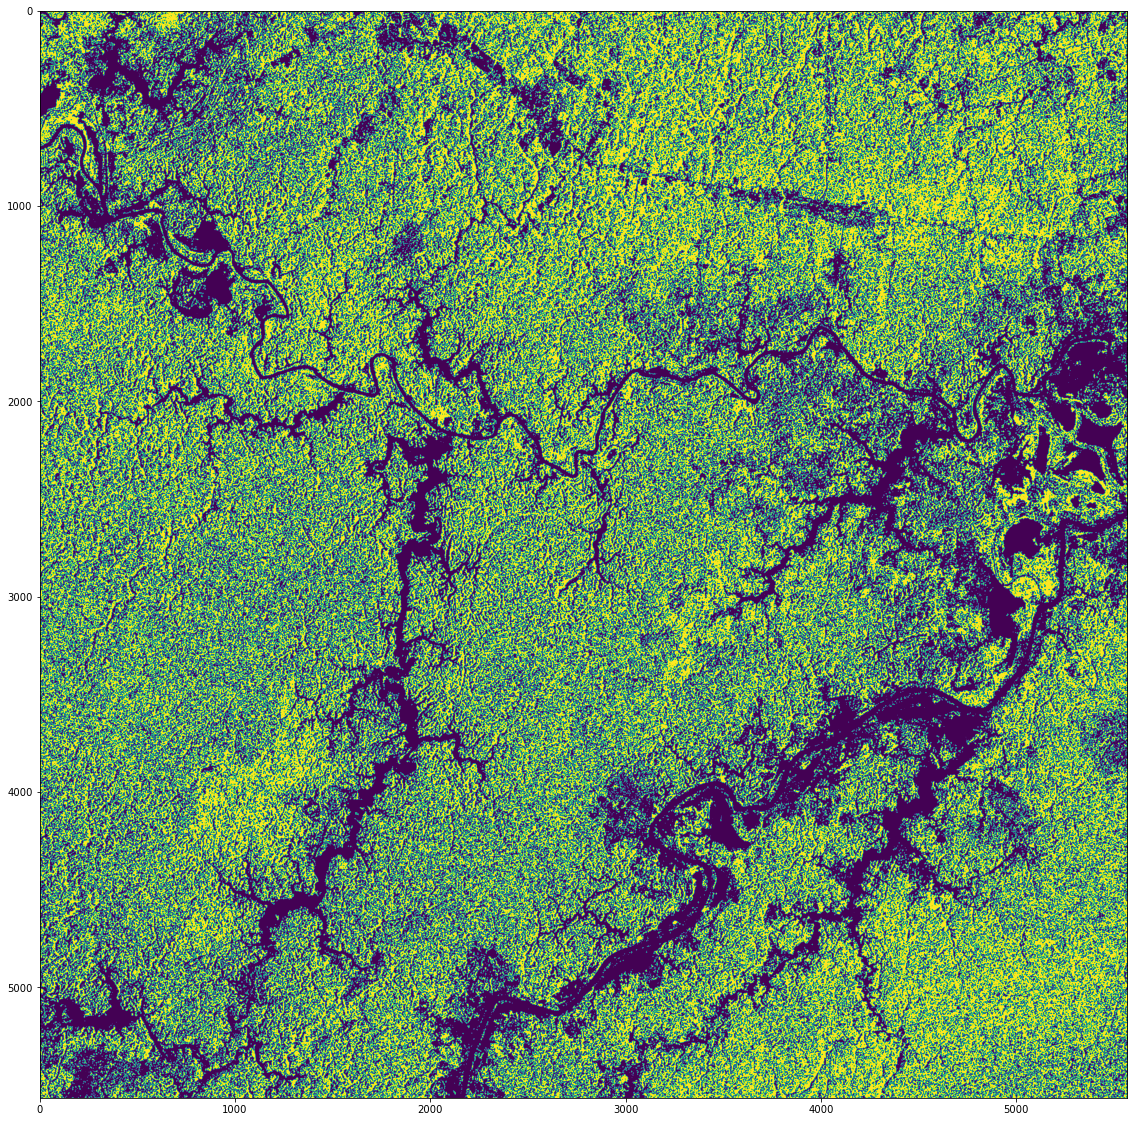

In [36]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster)
plt.show()

Changing the classification is straight forward. In this example choose MiniBatchKMeans

In [37]:
del k_means, X_cluster
gc.collect()

2592

In [41]:
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=2, init="k-means++")
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

Plot the result

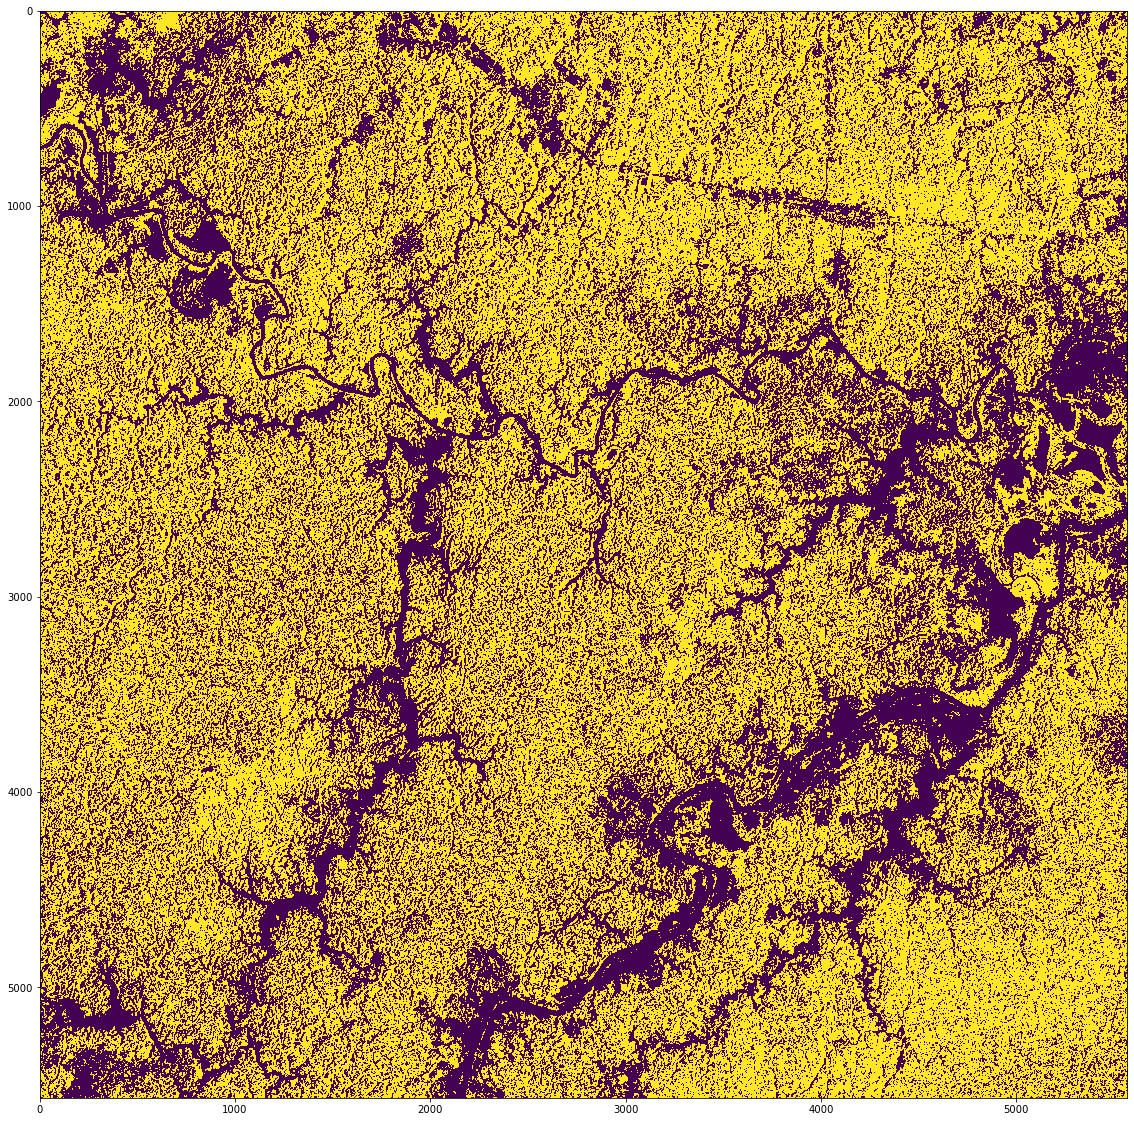

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap=cmap)

plt.show()

Final save the result to a new geotiff

In [40]:
# ds = gdal.Open(".../S2_may_South_coast_clip.tif")
# band = ds.GetRasterBand(2)
# arr = band.ReadAsArray()
# [cols, rows] = arr.shape

# format = "GTiff"
# driver = gdal.GetDriverByName(format)


# outDataRaster = driver.Create(".../k_means.gtif", rows, cols, 1, gdal.GDT_Byte)
# outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
# outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


# outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

# outDataRaster.FlushCache() ## remove from memory
# del outDataRaster ## delete the data (not the actual geotiff)